## Studets details

Student1
* Name: Shlomo Tannor
* ID: 314389248
* Username: shlomotannor

Student2
* Name: Naama Yochai
* ID: 208769737
* Username: naamayochai

Student3
* Name: Morris Alper
* ID: 341438711
* Username: morrisalper

### General tip

While debugging you might want to use:
```python
import importlib
importlib.reload(model)
```

to reload the model module without repeating unnecessary cells.

In [51]:
import importlib
importlib.reload(model)

<module 'model' from '/content/model.py'>

### Import relevant packages - you might need to pip install some 

In [2]:
import torch
import data_loader
from traineval import train, evaluate
import model as model

import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"deviced used is {device}")

deviced used is cuda


In [3]:
import numpy as np
import random

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [4]:
seed = 42

## Loading the Data

The following line of code invokes data_loader and will automatically download and extract the dataset if needed.
It instantiates the following variables;
* tokens_vocab - the sentence words vocabulary
* y_vocab - the labels (senses) vocabulary
* datasets - a dictionary with train,dev, and test WSDDataset instances.

Use the optional sentence_count kwarg to limit the number of sentences loaded.

In [5]:
train_dataset, tokens_vocab, y_vocab = data_loader.load_train_dataset()
train_dataset

Dataset was downloaded successfully and extracted to ./data


Samples: 204162 (no_sense: 0)
Sentences: 29740 (N=270)
Vocab:
	Tokens:39272
	Senses:25378

In [6]:
dev_dataset = data_loader.load_dev_dataset(tokens_vocab, y_vocab)
dev_dataset

Samples: 25619 (no_sense: 0)
Sentences: 3717 (N=134)
Vocab:
	Tokens:39272
	Senses:25378

## Part 1: Query-Based Attention

Implement the relevant parts in model.py module. You might to check out this blog post about [gather method](https://medium.com/analytics-vidhya/understanding-indexing-with-pytorch-gather-33717a84ebc4)

Load the model.

In [7]:
dropout = 0.25
D = 300
lr = 8e-5
batch_size=100
num_epochs=5
set_seed(seed)

m = model.WSDModel(
    tokens_vocab.size(), 
    y_vocab.size(), 
    D=D, 
    dropout_prob=dropout
).to(device)

optimizer = torch.optim.Adam(m.parameters(), lr=lr)

losses, train_acc, val_acc = train(
    m, optimizer, train_dataset, dev_dataset, num_epochs=num_epochs, batch_size=batch_size)

val: 0.501; epoch [4] loss: 2.750: 100%|██████████| 2042/2042 [00:28<00:00, 72.26it/s]


Train the model - you shoud see the loss decreasing and validation acc increasing from epoch to epoch.

In [8]:
print(f"Validation accuracy: {val_acc[-1]:.3f}, Training accuracy:{train_acc[-1]:.3f}")
assert round(val_acc[-1], 3) >= 0.514, "The last validation accuracy should be at least 0.514. Please check your implementation before you continue"

Validation accuracy: 0.515, Training accuracy:0.598


Plot the loss and training/validation accuracy. You should be getting ~54% validation accuracy after 10 epochs.

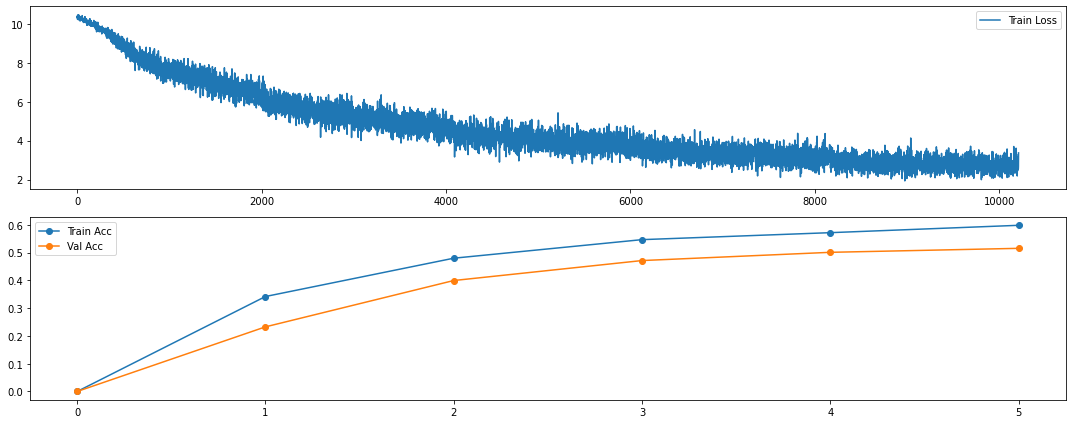

In [9]:
fig, axs = plt.subplots(nrows=2, figsize=(15, 6))

axs[0].plot(losses, '-', label='Train Loss');
axs[0].legend()
axs[1].plot(train_acc, '-o', label='Train Acc');
axs[1].plot(val_acc, '-o', label='Val Acc');
axs[1].legend()

plt.tight_layout()

Use the attention vizualization to get a feel of what the model is attending to.

The query token is highlighted in green, and the model's attention with a pink-blue gradient.
In addition, the loss is given a red gradient.

In [10]:
from traineval import higlight_samples

higlight_samples(m, dev_dataset, sample_size=5)

,index,query,query_token,y_true,y_pred,y_pred_prob,y_pred_loss,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133
0,0,1,is,be.v.01,be.v.01,7.243e-01,0.322517,It,is,natural,that,he,should,turn,for,his,major,support,to,a,select,and,dedicated,few,from,the,organization,which,actually,owns,the,university,and,whose,goals,are,",",in,their,opinion,",",identified,with,its,highest,good,and,(,to,use,that,<UNK>,phrase,),',the,attainment,of,excellence,'',',.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1,40,hearing,hearing_examiner.n.01,hearing_examiner.n.01,5.580e-01,0.583432,He,says,that,he,was,not,permitted,to,rebut,before,the,hearing,officer,statements,attributed,to,him,by,the,local,board,",",and,",",further,",",that,he,was,denied,at,trial,the,right,to,have,the,Department,of,Justice,hearing,officer,'s,report,and,the,original,report,of,the,Federal,Bureau,of,Investigation,as,to,his,claim,-,all,in,violation,of,the,Fifth,Amendment,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,2,10,then,then.r.01,then.r.01,7.743e-01,0.255836,The,contents,of,the,manifold,for,liquid,phase,experiments,were,then,mixed,by,shaking,",",redistributed,to,the,reaction,tubes,",",frozen,down,",",and,each,tube,was,then,sealed,off,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,3,25,seems,look.v.02,look.v.02,8.157e-01,0.203702,Instead,of,isolating,the,literal,flatness,by,<UNK>,and,circumscribing,it,",",the,pasted,paper,or,cloth,releases,and,spreads,it,",",and,the,artist,seems,to,have,nothing,left,but,this,undepicted,flatness,with,which,to,finish,as,well,as,start,his,picture,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,4,11,Schwartz,person.n.01,person.n.01,9.990e-01,0.000973,Without,dissent,",",senators,passed,a,bill,by,Sen.,A.,R.,Schwartz,of,<UNK>,authorizing,establishment,in,the,future,of,a,school,for,the,mentally,retarded,in,the,Gulf,Coast,district,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


The attention seems weird because it is almost uniform over all of the words, and has very small values. We do not see obviously higher attention for words we expected to be more important. Additionally, the padding receives similar weights to actual words.

## Part 2: Padding

Implement the padding mask in the attention function in model.py.

Load the model and retrain.

In [11]:
set_seed(seed)

m = model.WSDModel(
    tokens_vocab.size(), 
    y_vocab.size(), 
    D=D, 
    dropout_prob=dropout,
    use_padding=True
).to(device)

optimizer = torch.optim.Adam(m.parameters(), lr=lr)

losses, train_acc, val_acc = train(
    m, optimizer, train_dataset, dev_dataset, num_epochs=num_epochs, batch_size=batch_size)

val: 0.514; epoch [4] loss: 2.643: 100%|██████████| 2042/2042 [00:28<00:00, 71.92it/s]


In [12]:
print(f"Validation accuracy: {val_acc[-1]:.3f}, Training accuracy:{train_acc[-1]:.3f}")
assert round(val_acc[-1], 3) >= 0.527, "The last validation accuracy should be at least 0.527. Please check your implementation before you continue"

Validation accuracy: 0.527, Training accuracy:0.617


Plot the loss and training/validation accuracy.

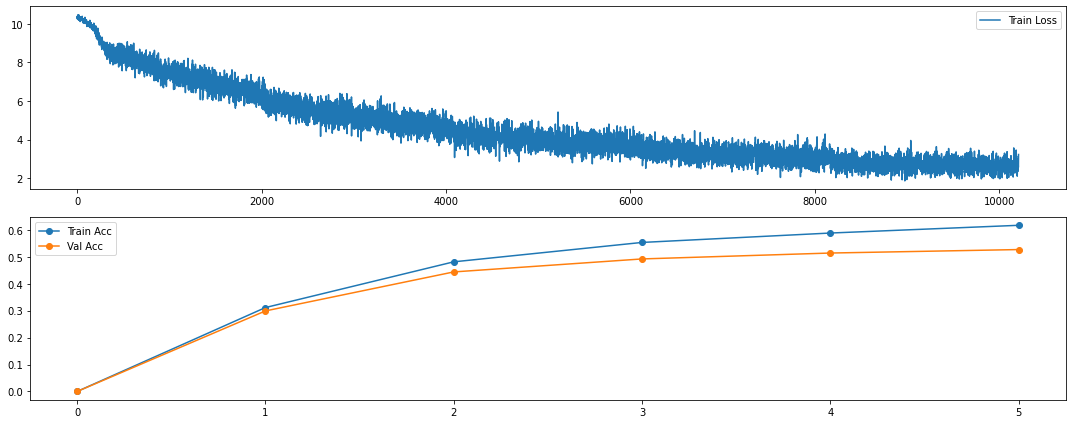

In [13]:
fig, axs = plt.subplots(nrows=2, figsize=(15, 6))

axs[0].plot(losses, '-', label='Train Loss');
axs[0].legend()
axs[1].plot(train_acc, '-o', label='Train Acc');
axs[1].plot(val_acc, '-o', label='Val Acc');
axs[1].legend()

plt.tight_layout()

In [14]:
higlight_samples(m, dev_dataset, sample_size=5)

,index,query,query_token,y_true,y_pred,y_pred_prob,y_pred_loss,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133
0,0,1,is,be.v.01,be.v.01,8.073e-01,0.214068,It,is,natural,that,he,should,turn,for,his,major,support,to,a,select,and,dedicated,few,from,the,organization,which,actually,owns,the,university,and,whose,goals,are,",",in,their,opinion,",",identified,with,its,highest,good,and,(,to,use,that,<UNK>,phrase,),',the,attainment,of,excellence,'',',.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1,40,hearing,hearing_examiner.n.01,hearing_examiner.n.01,5.185e-01,0.656892,He,says,that,he,was,not,permitted,to,rebut,before,the,hearing,officer,statements,attributed,to,him,by,the,local,board,",",and,",",further,",",that,he,was,denied,at,trial,the,right,to,have,the,Department,of,Justice,hearing,officer,'s,report,and,the,original,report,of,the,Federal,Bureau,of,Investigation,as,to,his,claim,-,all,in,violation,of,the,Fifth,Amendment,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,2,10,then,then.r.01,then.r.01,7.786e-01,0.250271,The,contents,of,the,manifold,for,liquid,phase,experiments,were,then,mixed,by,shaking,",",redistributed,to,the,reaction,tubes,",",frozen,down,",",and,each,tube,was,then,sealed,off,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,3,25,seems,look.v.02,look.v.02,8.290e-01,0.187492,Instead,of,isolating,the,literal,flatness,by,<UNK>,and,circumscribing,it,",",the,pasted,paper,or,cloth,releases,and,spreads,it,",",and,the,artist,seems,to,have,nothing,left,but,this,undepicted,flatness,with,which,to,finish,as,well,as,start,his,picture,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,4,11,Schwartz,person.n.01,person.n.01,9.986e-01,0.001352,Without,dissent,",",senators,passed,a,bill,by,Sen.,A.,R.,Schwartz,of,<UNK>,authorizing,establishment,in,the,future,of,a,school,for,the,mentally,retarded,in,the,Gulf,Coast,district,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


Examine additional examples, using the API and pandas as demonstrated below.

In [15]:
import pandas as pd
import numpy as np
from traineval import evaluate_verbose, highlight

pd.set_option('max_columns', 100)

eval_df, attention_df = evaluate_verbose(m, dev_dataset, iter_lim=100)

Visualization of 5 incorrectly classified examples.

In [16]:
idxs = np.where(eval_df['y_true'] != eval_df['y_pred'])
idxs = list(idxs[0][:5])
highlight(eval_df, attention_df, idxs)

,index,query,query_token,y_true,y_pred,y_pred_prob,y_pred_loss,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133
0,0,7,men,work_force.n.01,man.n.01,1.087e-01,2.219350,It,included,the,top,O,',Banion,men,and,Chief,of,<UNK>,Michael,Hughes,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1,3,get,arrive.v.01,get.v.01,1.115e-01,2.193304,How,did,we,get,here,'',?,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,3,8,establish,establish.v.02,establish.v.01,3.810e-01,0.964986,His,purpose,",",however,",",was,not,to,establish,an,empire,",",but,to,assert,the,principle,of,divine,justice,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,4,41,thinking,think.v.02,think.v.03,9.456e-02,2.358525,Instead,of,her,old,confidence,in,the,simplest,",",purest,",",most,moving,musical,expression,",",Miss,Schwarzkopf,is,letting,herself,be,tempted,by,the,classic,sin,of,artistic,pride,-,that,subtle,vanity,that,sometimes,<UNK>,a,great,artist,into,thinking,that,he,or,she,can,somehow,better,the,music,by,bringing,to,it,something,extra,",",some,personal,dramatic,touch,imposed,from,the,outside,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6,6,12,as,so_far.r.01,such_as.s.00,1.997e-02,3.913649,If,private,brand,competition,has,n't,been,felt,in,your,product,field,as,yet,",",have,you,thought,how,you,will,cope,with,it,if,and,when,it,does,appear,?,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


Visualization of examples with the query word "left".

In [17]:
idxs = np.where(eval_df['query_token'] == 'left')
highlight(eval_df, attention_df, idxs)

,index,query,query_token,y_true,y_pred,y_pred_prob,y_pred_loss,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133
333,333,17,left,left.a.01,leave.v.01,8.681e-02,2.444054,Start,with,the,class,standing,in,a,circle,",",with,weight,on,the,right,foot,and,the,left,extended,a,little,way,into,the,circle,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
734,734,1,left,leave.v.02,leave.v.01,4.891e-02,3.017734,Chandler,left,Carroll,at,the,bottom,of,the,hill,to,direct,any,reinforcements,he,could,find,to,the,fight,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1029,1029,24,left,left_ventricle.n.01,leave.v.01,1.367e-03,6.595127,It,is,also,possible,to,utilize,a,pressure,transducer,",",mounted,at,the,end,of,a,<UNK>,which,is,inserted,into,the,heart,'s,left,ventricle,",",to,indicate,the,blood,pressure,in,the,heart,itself,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2311,2311,29,left,leftover.s.01,leave.v.01,7.002e-02,2.658987,Instead,of,isolating,the,literal,flatness,by,<UNK>,and,circumscribing,it,",",the,pasted,paper,or,cloth,releases,and,spreads,it,",",and,the,artist,seems,to,have,nothing,left,but,this,undepicted,flatness,with,which,to,finish,as,well,as,start,his,picture,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2881,2881,2,left,leave.v.04,leave.v.01,2.117e-02,3.855286,He,had,left,her,inviolate,",",thinking,familiarity,would,gentle,her,in,time,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3109,3109,4,left,leave.v.01,leave.v.01,4.868e-01,0.719959,``,Just,<UNK>,he,left,<UNK>,his,<UNK>,we,<UNK>,hevin,<UNK>,on,the,<UNK>,",",Major,Roebuck,an,Ah,",",an,<UNK>,says,',May,Ah,<UNK>,one,too,',?,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3390,3390,9,left,leave.v.01,leave.v.01,4.603e-01,0.775806,By,this,time,large,numbers,of,the,audience,had,left,the,hall,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3605,3605,5,left,leave.v.02,leave.v.01,5.594e-02,2.883403,My,men,",",they,all,left,me,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4477,4477,12,left,leave.v.02,leave.v.01,5.184e-02,2.959642,The,proteins,and,fats,are,burned,off,",",and,the,cholesterol,is,left,behind,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4705,4705,1,left,leave.v.01,leave.v.01,5.579e-01,0.583597,Beckworth,left,the,tent,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


We set the softmax input to minus infinity for padding tokens so they get 0 attention.

## Part 3: Self-Attention

The method below converts the query-based instances in WSDDataset to sentence-level instances in WSDSentencesDataset for self-attention.

Notice how the number of samples now equals number of sentences.

In [53]:
sa_train_dataset = data_loader.WSDSentencesDataset.from_word_dataset(train_dataset)
sa_train_dataset

Samples: 29740
Sentences: 29740 (N=270)
Vocab:
	Tokens:39272
	Senses:25378

In [54]:
sa_dev_dataset = data_loader.WSDSentencesDataset.from_word_dataset(dev_dataset)
sa_dev_dataset

Samples: 3717
Sentences: 3717 (N=134)
Vocab:
	Tokens:39272
	Senses:25378

Implement self-attention in the model.

Load the model and retrain.

In [55]:
lr=2e-4
dropout = 0.2
D=300
batch_size=20
num_epochs=5
set_seed(seed)

m = model.WSDModel(
    tokens_vocab.size(), 
    y_vocab.size(), 
    D=D, 
    dropout_prob=dropout,
    use_padding=True
).to(device)

optimizer = torch.optim.Adam(m.parameters(), lr=lr)

losses, train_acc, val_acc = train(
    m, optimizer, sa_train_dataset, sa_dev_dataset, num_epochs=num_epochs, batch_size=batch_size)

val: 0.540; epoch [4] loss: 1.733: 100%|██████████| 1487/1487 [01:34<00:00, 15.80it/s]


Plot the loss and training/validation accuracy.

In [56]:
print(f"Validation accuracy: {val_acc[-1]:.3f}, Training accuracy:{train_acc[-1]:.3f}")
# assert val_acc[-1] >= 0.543, "The last validation accuracy should be at least 0.543. Please check your implementation before you continue"
assert val_acc[-1] >= 0.542, "The last validation accuracy should be at least 0.543. Please check your implementation before you continue"

Validation accuracy: 0.543, Training accuracy:0.673


In [57]:
val_acc[-1]


0.5426441313087943

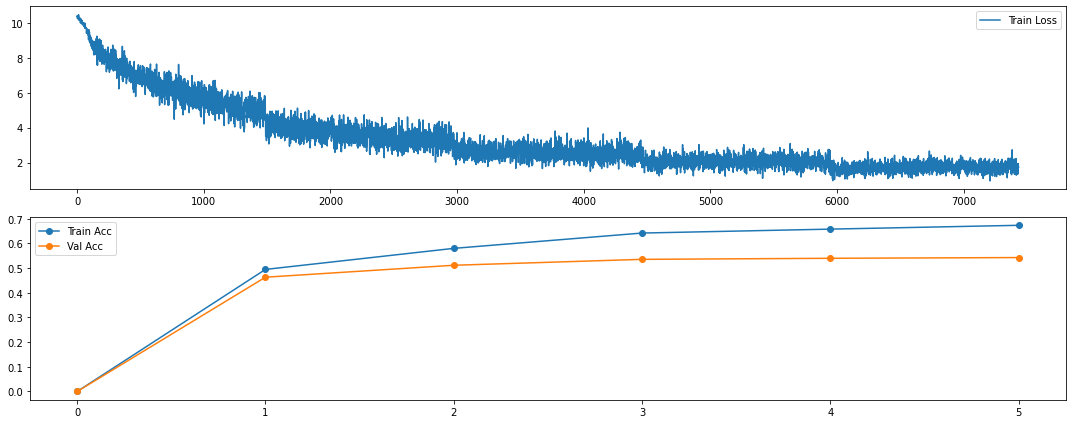

In [58]:
fig, axs = plt.subplots(nrows=2, figsize=(15, 6))

axs[0].plot(losses, '-', label='Train Loss');
axs[0].legend()
axs[1].plot(train_acc, '-o', label='Train Acc');
axs[1].plot(val_acc, '-o', label='Val Acc');
axs[1].legend()

plt.tight_layout()

In [59]:
higlight_samples(m, dev_dataset, sample_size=5, self_attention=True)

,index,query,query_token,y_true,y_pred,y_pred_prob,y_pred_loss,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133
0,0,7,Lincoln,person.n.01,location.n.01,1.199e-01,2.120954,Similarly,",",when,a,reporter,once,questioned,Lincoln,in,<UNK>,fashion,",",Lincoln,refused,to,make,any,further,statement,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1,13,saw,see.v.01,see.v.01,7.896e-01,0.236182,He,said,he,was,the,lonely,type,and,working,in,a,cellar,you,saw,funny,things,coming,out,of,the,cracks,in,the,wall,if,they,was,n't,nobody,with,you,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,2,6,of,think_of.v.03,remember.v.02,1.950e-01,1.634883,Younger,men,usually,do,n't,think,of,pensions,as,an,important,job,benefit,factor,anyhow,and,they,'re,liable,to,change,jobs,several,times,before,settling,down,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,3,7,however,however.r.01,however.r.01,9.635e-01,0.037158,Joel,knew,what,he,was,about,",",however,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,4,17,constituent,component.n.03,component.n.03,9.012e-01,0.104006,In,the,over-all,process,",",it,is,difficult,to,assign,a,``,pure,'',role,to,each,constituent,of,a,built,detergent,formulation,;,and,",",indeed,",",there,is,no,more,reason,to,separate,the,interrelated,roles,of,the,active,",",builder,",",<UNK>,agent,",",etc.,than,there,is,to,assign,individual,actions,to,each,of,the,numerous,<UNK>,making,up,a,given,commercial,organic,active,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


Performance improved by 3% on validation set to 0.54 accuracy. The model seems to converge after less epochs. We believe this is due to the fact that a single training sample is a complete sentence and not a single word, and thus the model learns much more from a given "sample".

## Part 4: Positional embeddings


We do not provide "you code here" comments for this part as you should be familiar with the code by now

In [60]:
# TODO: your experiments here
lr=2e-4
dropout = 0.2
D=300
batch_size=20
num_epochs=5
set_seed(seed)

m = model.WSDModel(
    tokens_vocab.size(), 
    y_vocab.size(), 
    D=D, 
    dropout_prob=dropout,
    use_padding=True,
    positional=True
).to(device)

optimizer = torch.optim.Adam(m.parameters(), lr=lr)

losses, train_acc, val_acc = train(
    m, optimizer, sa_train_dataset, sa_dev_dataset, num_epochs=num_epochs, batch_size=batch_size)

val: 0.568; epoch [4] loss: 1.598: 100%|██████████| 1487/1487 [01:33<00:00, 15.83it/s]


Validation accuracy: 0.581, Training accuracy:0.711


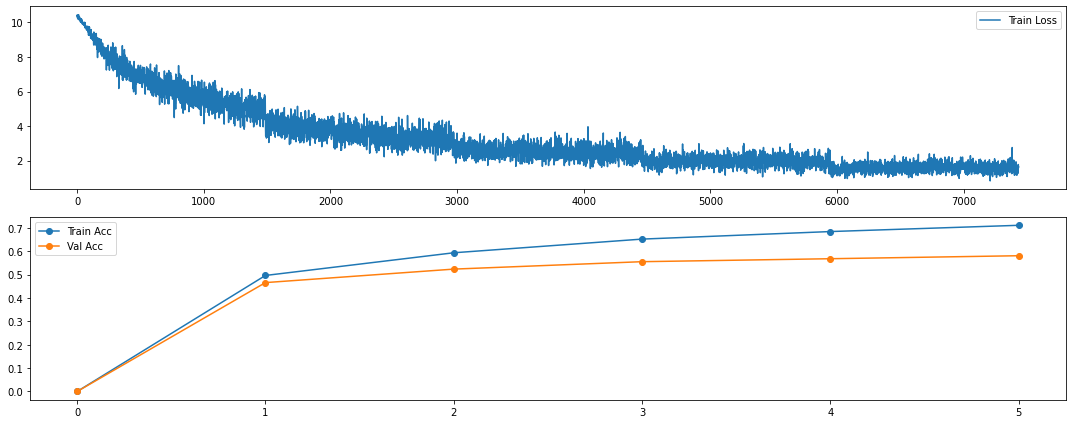

In [61]:
print(f"Validation accuracy: {val_acc[-1]:.3f}, Training accuracy:{train_acc[-1]:.3f}")
fig, axs = plt.subplots(nrows=2, figsize=(15, 6))

axs[0].plot(losses, '-', label='Train Loss');
axs[0].legend()
axs[1].plot(train_acc, '-o', label='Train Acc');
axs[1].plot(val_acc, '-o', label='Val Acc');
axs[1].legend()

plt.tight_layout()

In [63]:
higlight_samples(m, dev_dataset, sample_size=5, self_attention=True)

,index,query,query_token,y_true,y_pred,y_pred_prob,y_pred_loss,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133
0,0,7,Lincoln,person.n.01,location.n.01,3.526e-01,1.042485,Similarly,",",when,a,reporter,once,questioned,Lincoln,in,<UNK>,fashion,",",Lincoln,refused,to,make,any,further,statement,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1,13,saw,see.v.01,see.v.01,7.063e-01,0.347716,He,said,he,was,the,lonely,type,and,working,in,a,cellar,you,saw,funny,things,coming,out,of,the,cracks,in,the,wall,if,they,was,n't,nobody,with,you,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,2,6,of,think_of.v.03,think_of.v.03,5.609e-01,0.578238,Younger,men,usually,do,n't,think,of,pensions,as,an,important,job,benefit,factor,anyhow,and,they,'re,liable,to,change,jobs,several,times,before,settling,down,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,3,7,however,however.r.01,however.r.01,8.088e-01,0.212151,Joel,knew,what,he,was,about,",",however,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,4,17,constituent,component.n.03,component.n.03,9.462e-01,0.055277,In,the,over-all,process,",",it,is,difficult,to,assign,a,``,pure,'',role,to,each,constituent,of,a,built,detergent,formulation,;,and,",",indeed,",",there,is,no,more,reason,to,separate,the,interrelated,roles,of,the,active,",",builder,",",<UNK>,agent,",",etc.,than,there,is,to,assign,individual,actions,to,each,of,the,numerous,<UNK>,making,up,a,given,commercial,organic,active,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


Performance improved from 0.543 to 0.581, after incoporating positional information.
Additionally, we see in the attention visualization that the model gives higher scores to local neighbors of the query.

## Part 5: Causal Attention

We do not provide "you code here" comments for this part as you should be familiar with the code by now

In [64]:
# TODO: your experiments here
lr=2e-4
dropout = 0.2
D=300
batch_size=20
num_epochs=5
set_seed(seed)

m = model.WSDModel(
    tokens_vocab.size(), 
    y_vocab.size(), 
    D=D, 
    dropout_prob=dropout,
    use_padding=True,
    positional=True,
    causal=True
).to(device)

optimizer = torch.optim.Adam(m.parameters(), lr=lr)

losses, train_acc, val_acc = train(
    m, optimizer, sa_train_dataset, sa_dev_dataset, num_epochs=num_epochs, batch_size=batch_size)

val: 0.559; epoch [4] loss: 1.686: 100%|██████████| 1487/1487 [01:34<00:00, 15.81it/s]


Validation accuracy: 0.565, Training accuracy:0.682


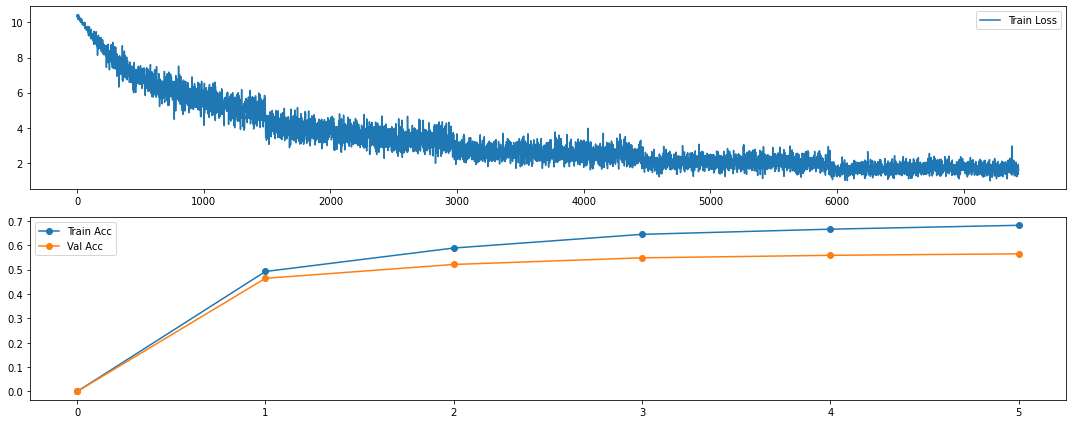

In [65]:
print(f"Validation accuracy: {val_acc[-1]:.3f}, Training accuracy:{train_acc[-1]:.3f}")
fig, axs = plt.subplots(nrows=2, figsize=(15, 6))

axs[0].plot(losses, '-', label='Train Loss');
axs[0].legend()
axs[1].plot(train_acc, '-o', label='Train Acc');
axs[1].plot(val_acc, '-o', label='Val Acc');
axs[1].legend()

plt.tight_layout()

In [66]:
higlight_samples(m, dev_dataset, sample_size=5, self_attention=True)

,index,query,query_token,y_true,y_pred,y_pred_prob,y_pred_loss,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133
0,0,7,Lincoln,person.n.01,person.n.01,8.734e-01,0.135403,Similarly,",",when,a,reporter,once,questioned,Lincoln,in,<UNK>,fashion,",",Lincoln,refused,to,make,any,further,statement,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1,13,saw,see.v.01,see.v.01,7.416e-01,0.298899,He,said,he,was,the,lonely,type,and,working,in,a,cellar,you,saw,funny,things,coming,out,of,the,cracks,in,the,wall,if,they,was,n't,nobody,with,you,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,2,6,of,think_of.v.03,think_of.v.03,3.349e-01,1.093850,Younger,men,usually,do,n't,think,of,pensions,as,an,important,job,benefit,factor,anyhow,and,they,'re,liable,to,change,jobs,several,times,before,settling,down,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,3,7,however,however.r.01,however.r.01,8.360e-01,0.179091,Joel,knew,what,he,was,about,",",however,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,4,17,constituent,component.n.03,component.n.03,9.119e-01,0.092206,In,the,over-all,process,",",it,is,difficult,to,assign,a,``,pure,'',role,to,each,constituent,of,a,built,detergent,formulation,;,and,",",indeed,",",there,is,no,more,reason,to,separate,the,interrelated,roles,of,the,active,",",builder,",",<UNK>,agent,",",etc.,than,there,is,to,assign,individual,actions,to,each,of,the,numerous,<UNK>,making,up,a,given,commercial,organic,active,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


We can see now that the performance of the model decreased from 0.581 to 0.565, this is expected as the model uses less information to make predictions.
Additionally, in the visualization of the attention we can see that all the words after the query are not used in the prediction (colored in black).